# Physionet Project - 2020

### By: Kashif Siddiqui

**Description:** Classification of 108 diagnostic classes based on the Physionet datasets for the 2020 competition.

**F_E =** Feature Extraction - This notebook contains code for the pre-processing step of the pipeline

### Initializing

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='2'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import csv
import gc
from time import time
import logging
from scipy.io import loadmat
from select_win import select_win,select_windows
import load_data as ldfile
import create_model as cmodel

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from scipy.signal import butter, sosfilt, sosfilt_zi, sosfiltfilt, lfilter, lfilter_zi, filtfilt, sosfreqz, resample
#from utils import hamilton_detector, christov_detector, findpeaks, engzee_detector
from ecg_detectors.ecgdetectors import Detectors, MWA, panPeakDetect, searchBack

np.random.seed(354)
sns.set()
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.random.set_seed(1342) # Set seed for reproducibility


### Locating Data Directory

In [2]:
t1 = time()
input_directory = '/dataset/PhysioNet2020/WFDB' # Dataset on beastie 
train_data,train_labels_bin,val_data,val_labels_bin = ldfile.load_data2D_bin(input_directory) 
#train_dataset,val_dataset = ldfile.load_tf(train_data,train_labels_bin,val_data,val_labels_bin)
t2 = time()
print('Loading data in {} seconds.'.format(round(t2-t1)))
#del train_data,train_labels_bin,val_data,val_labels_bin
#gc.collect()

total number of files:  21837
Number of files for trainig:  17469
Number of files for validation:  2183
Number of files for testing:  2183
500 files were loaded for training!
1000 files were loaded for training!
1500 files were loaded for training!
2000 files were loaded for training!
2500 files were loaded for training!
3000 files were loaded for training!
3500 files were loaded for training!
4000 files were loaded for training!
4500 files were loaded for training!
5000 files were loaded for training!
5500 files were loaded for training!
6000 files were loaded for training!
6500 files were loaded for training!
7000 files were loaded for training!
7500 files were loaded for training!
8000 files were loaded for training!
8500 files were loaded for training!
9000 files were loaded for training!
9500 files were loaded for training!
10000 files were loaded for training!
10500 files were loaded for training!
11000 files were loaded for training!
11500 files were loaded for training!
12000 f

### Loading Data 

In [3]:
who

Detectors	 MWA	 cmodel	 csv	 gc	 input_directory	 keras	 layers	 ldfile	 
loadmat	 logging	 mpimg	 np	 os	 panPeakDetect	 plt	 searchBack	 select_win	 
select_windows	 sns	 t1	 t2	 tf	 time	 train_dataset	 val_dataset	 warnings	 



In [4]:
for f, l in train_dataset.take(1):
    print("Shape of one Batch features array:", f.numpy().shape)
    print("Shape of one Batch labels array:", l.numpy().shape)

Shape of one Batch features array: (128, 12, 2500, 1)
Shape of one Batch labels array: (128, 9)


### RNN

In [4]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim= 1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


### BiRNN

In [53]:
model_name = 'test3'
show_stats= True
model = keras.Sequential()
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(512, return_sequences=True), input_shape=(12,2500), merge_mode = 'ave'))
model.add(layers.BatchNormalization())
model.add(layers.Bidirectional(layers.LSTM(128), input_shape =(12, 1024)))
#model.add(layers.BatchNormalization())
#model.add(layers.Bidirectional.build(layers.LSTM(128), input_shape = (12, 512)))
#model.add(layers.BatchNormalization())
#model.add(layers.Bidirectional.build(layers.LSTM(64), input_shape =(12,256)))
model.add(layers.Dense(100))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(50))
model.add(layers.Activation('softmax'))
#model.summary()

In [54]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["mae", "acc"])
#model.compile(optimizer="Adam", loss="mse", metrics=["acc"])


In [55]:
train_data.shape
val_data.shape

(6326, 12, 2500)

In [56]:
type(train_data)

numpy.ndarray

In [57]:
#train_data=np.reshape(train_data,(, 12, 2500))
train_data=np.reshape(train_data,(50764, 12, 2500))
#val_data=np.reshape(val_data,(3532, 12, 2500))
val_data=np.reshape(val_data,(6326, 12, 2500))


In [58]:
print('train_shape:', train_data.shape)
print('val_shape:', val_data.shape)

train_shape: (50764, 12, 2500)
val_shape: (6326, 12, 2500)


In [59]:
RNN_v01=model.fit(train_data,train_labels_bin, batch_size=150, epochs = 100, validation_data=(val_data,val_labels_bin ), steps_per_epoch=20)

Epoch 1/100
20/20 [==============================] - 12s 584ms/step - loss: 0.1632 - mae: 0.0553 - acc: 0.3477 - val_loss: 0.1791 - val_mae: 0.0653 - val_acc: 0.3865
Epoch 2/100
20/20 [==============================] - 11s 535ms/step - loss: 0.1405 - mae: 0.0497 - acc: 0.4030 - val_loss: 0.1645 - val_mae: 0.0630 - val_acc: 0.3957
Epoch 3/100
20/20 [==============================] - 11s 537ms/step - loss: 0.1372 - mae: 0.0495 - acc: 0.3940 - val_loss: 0.1510 - val_mae: 0.0587 - val_acc: 0.3987
Epoch 4/100
20/20 [==============================] - 11s 537ms/step - loss: 0.1355 - mae: 0.0492 - acc: 0.4023 - val_loss: 0.1413 - val_mae: 0.0550 - val_acc: 0.4039
Epoch 5/100
20/20 [==============================] - 11s 535ms/step - loss: 0.1319 - mae: 0.0477 - acc: 0.4233 - val_loss: 0.1398 - val_mae: 0.0550 - val_acc: 0.4142
Epoch 6/100
20/20 [==============================] - 11s 535ms/step - loss: 0.1295 - mae: 0.0476 - acc: 0.4357 - val_loss: 0.1350 - val_mae: 0.0521 - val_acc: 0.4126
Epoc

In [60]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_49 (Batc (None, 12, 2500)          10000     
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 12, 512)           12341248  
_________________________________________________________________
batch_normalization_50 (Batc (None, 12, 512)           2048      
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 256)               656384    
_________________________________________________________________
dense_14 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)              

In [9]:
#trying with batch normalization
RNN_v01=model.fit(train_data,train_labels_bin, batch_size=150, epochs = 20, validation_data=(val_data,val_labels_bin ), steps_per_epoch=20)

Epoch 1/20
20/20 [==============================] - 4s 176ms/step - loss: 5.8876 - acc: 0.5817 - val_loss: 0.1091 - val_acc: 0.9278
Epoch 2/20
20/20 [==============================] - 2s 108ms/step - loss: 3.4176 - acc: 0.5852 - val_loss: 0.0822 - val_acc: 0.9458
Epoch 3/20
20/20 [==============================] - 2s 108ms/step - loss: 2.4174 - acc: 0.6166 - val_loss: 0.0756 - val_acc: 0.9461
Epoch 4/20
20/20 [==============================] - 2s 109ms/step - loss: 1.8105 - acc: 0.6234 - val_loss: 0.0737 - val_acc: 0.9462
Epoch 5/20
20/20 [==============================] - 2s 107ms/step - loss: 1.5514 - acc: 0.6199 - val_loss: 0.0736 - val_acc: 0.9486
Epoch 6/20
20/20 [==============================] - 2s 108ms/step - loss: 1.2475 - acc: 0.6591 - val_loss: 0.0727 - val_acc: 0.9481
Epoch 7/20
20/20 [==============================] - 2s 107ms/step - loss: 1.0655 - acc: 0.6686 - val_loss: 0.0707 - val_acc: 0.9480
Epoch 8/20
20/20 [==============================] - 2s 108ms/step - loss: 0.

In [9]:
RNN_v03=model.fit(train_data,train_labels_bin, batch_size=150, epochs = 20, validation_data=(val_data,val_labels_bin ), steps_per_epoch=20)

Epoch 1/20
20/20 [==============================] - 4s 176ms/step - loss: 0.5195 - acc: 0.7330 - val_loss: 0.0943 - val_acc: 0.9399
Epoch 2/20
20/20 [==============================] - 2s 108ms/step - loss: 0.3150 - acc: 0.7862 - val_loss: 0.0706 - val_acc: 0.9478
Epoch 3/20
20/20 [==============================] - 2s 109ms/step - loss: 0.2495 - acc: 0.8171 - val_loss: 0.0625 - val_acc: 0.9490
Epoch 4/20
20/20 [==============================] - 2s 109ms/step - loss: 0.1925 - acc: 0.8455 - val_loss: 0.0593 - val_acc: 0.9490
Epoch 5/20
20/20 [==============================] - 2s 108ms/step - loss: 0.1582 - acc: 0.8799 - val_loss: 0.0572 - val_acc: 0.9490
Epoch 6/20
20/20 [==============================] - 2s 109ms/step - loss: 0.1375 - acc: 0.8916 - val_loss: 0.0556 - val_acc: 0.9490
Epoch 7/20
20/20 [==============================] - 2s 109ms/step - loss: 0.1268 - acc: 0.8992 - val_loss: 0.0543 - val_acc: 0.9490
Epoch 8/20
20/20 [==============================] - 2s 108ms/step - loss: 0.

In [61]:
model.save(model_name)

In [62]:
Train_accuracy = model.evaluate(train_data, train_labels_bin)

1587/1587 [==============================] - 78s 49ms/step - loss: 0.0783 - mae: 0.0358 - acc: 0.5553


In [63]:
Val_accuracy = model.evaluate(val_data, val_labels_bin)

198/198 [==============================] - 10s 49ms/step - loss: 0.1342 - mae: 0.0424 - acc: 0.4469


### PLOTTING

In [64]:
Test_acc = RNN_v01.history['acc']
print(Test_acc)
Val_acc = RNN_v01.history['val_acc']
print(Val_acc)
epochs = range(len(Test_acc))

[0.3476666808128357, 0.40299999713897705, 0.39399999380111694, 0.4023333191871643, 0.4233333468437195, 0.43566668033599854, 0.4156666696071625, 0.42399999499320984, 0.429666668176651, 0.42233332991600037, 0.43799999356269836, 0.4423333406448364, 0.4326666593551636, 0.43533334136009216, 0.43666666746139526, 0.4243333339691162, 0.4402882754802704, 0.45533332228660583, 0.4650000035762787, 0.45366665720939636, 0.44866666197776794, 0.4633333384990692, 0.4663333296775818, 0.4586666524410248, 0.4440000057220459, 0.4723333418369293, 0.4556666612625122, 0.44566667079925537, 0.44200000166893005, 0.4490000009536743, 0.4573333263397217, 0.4556666612625122, 0.45266667008399963, 0.448867529630661, 0.49000000953674316, 0.4869999885559082, 0.4753333330154419, 0.47566667199134827, 0.4906666576862335, 0.49033331871032715, 0.48500001430511475, 0.4846666753292084, 0.4713333249092102, 0.47433334589004517, 0.4729999899864197, 0.4883333444595337, 0.4753333330154419, 0.46799999475479126, 0.46799999475479126, 

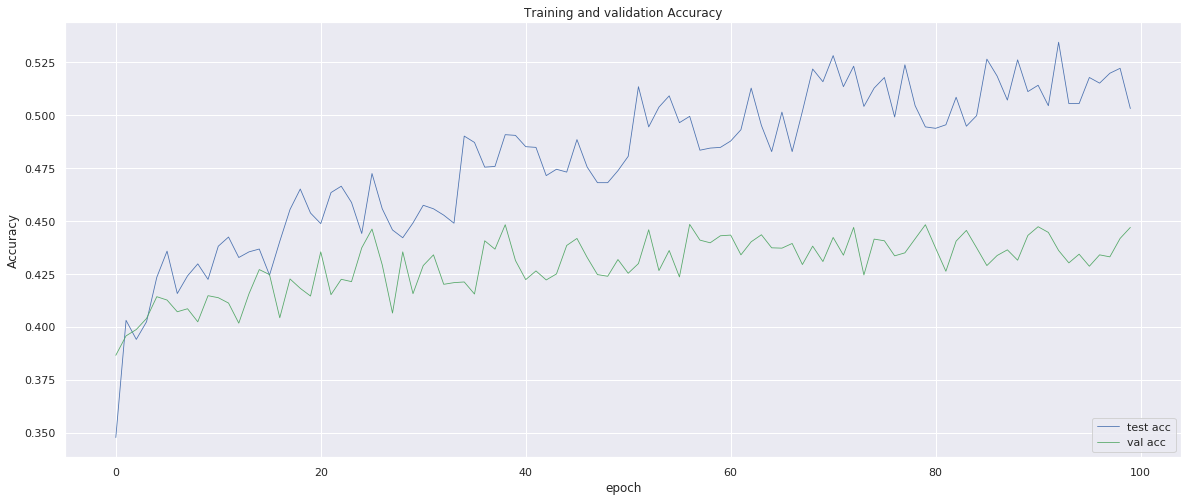

In [65]:
plt.figure(figsize=(20, 8))
plt.clf()
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.title('Training and validation Accuracy')
plt.plot(epochs,Test_acc,"b", linewidth=0.8, label="test acc")
plt.plot(epochs,Val_acc,"g", linewidth=0.8, label="val acc")
plt.legend(loc="lower right")
plt.show()

### Testing

In [66]:
from sklearn.preprocessing import MultiLabelBinarizer

def save_challenge_predictions(output_directory,filename,scores,labels,classes):
    recording = os.path.splitext(filename)[0]
    new_file = filename.replace('.mat','.csv')
    output_file = os.path.join(output_directory,new_file)

    # Include the filename as the recording number
    recording_string = '#{}'.format(recording)
    class_string = ','.join(classes)
    label_string = ','.join(str(i) for i in labels)
    score_string = ','.join(str(i) for i in scores)

    with open(output_file, 'w') as f:
        f.write(recording_string + '\n' + class_string + '\n' + label_string + '\n' + score_string + '\n')


def test_classifier_files_bin(input_directory,TXTfile,output_directory,model,win_size=5, fs=500,thresh=0.5):
    # inputs:
    # fs: signal frequency
    # Find files. List of files for testing is in the TXTfile which was created in load_data2D() version 04
    input_files = []
    with open(TXTfile,'r') as f:
        file_list=f.readlines()
    for line in file_list:
        input_files.append(line.strip())
    
    all_files = []
    for f in os.listdir(input_directory):
        if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
            all_files.append(f)

    classes = ldfile.get_classes(input_directory,all_files)
    num_classes = len(classes)
    
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)

    # Load model.    
    print('Loading BiRNN model...')
    
    # loaded_model = tf.keras.models.load_model(model_directory)
    #model2 = tf.keras.Sequential([loaded_model, tf.keras.layers.Softmax()])
    model2 = model
    model2.summary()

    # Iterate over files.
    print('Reading testing files ...')
    num_files = len(input_files)
    print('Number of files (in TXT file):', num_files)
    counter = 0
    count_correct_classification = {}
    label_true = []
    label_pred = []

    all_test_labels =[]
    for i, f in enumerate(input_files):
        tmp_input_file = os.path.join(input_directory, f)
        data, header_data = ldfile.load_challenge_data(tmp_input_file)
        signal_label = header_data[15].split()[1].split(',')      # [0] # Only take first
        all_test_labels.append(signal_label)

    # Fit the multi-label binarizer on the testing set
    print("Labels:")
    mlb = MultiLabelBinarizer()
    mlb.fit(all_test_labels)
    # Loop over all labels and show them
    N_LABELS = len(mlb.classes_)
    for (i, label) in enumerate(mlb.classes_):
        print("{}. {}".format(i, label))

    flag = True
    for i, f in enumerate(input_files):
        tmp_input_file = os.path.join(input_directory, f)
        data, header_data = ldfile.load_challenge_data(tmp_input_file)

        # preparing data for classifier     
        test_data = []
        test_labels = []
        #win_size=5 # 5 second window
        win_start = select_win(input_directory, f, win_size)

        temp = []
        for j in [0,1,2,3,4,5,6,7,8,9,10,11]: # len(data) is 35 for 12-lead signals
            temp.append(data[j][win_start:win_start+win_size*fs])
            #print(i)
        test_data.append(temp) 
        test_data = np.asarray(test_data,dtype=np.float64)
        dim = test_data.shape
        print(dim)
        test_data = test_data.reshape(dim[0],dim[1],dim[2])
        print(test_data.shape)
        
        
        #test_data = test_data.reshape(dim[0],dim[1],dim[2],1)
        #train_data=np.reshape(train_data,(50764, 12, 2500))

        signal_label = header_data[15].split()[1].split(',')      # [0] # Only take first
        test_labels.append(signal_label)
        # transform the test labels 
        test_labels_bin = mlb.transform(test_labels)
        if flag:
            print('test_labels_bin: ', test_labels_bin)
        
        # Create batch
        test_data_slice = tf.data.Dataset.from_tensor_slices((test_data, test_labels_bin))
        test_data_slice = test_data_slice.batch(1) # Create batch the same size as the number of samples
        
        print(test_data_slice)
        print('npiterator:')
        list(test_data_slice.as_numpy_iterator())
        # Applying Model
        # current_label = np.zeros(num_classes, dtype=int)
        # current_score = np.zeros(num_classes)
        y_hat = model2.predict(test_data_slice)[0]
        print(y_hat)
        y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
        print('ypred just got done!!!')
        
        if np.sum(y_pred)==0:
            y_hat[np.argmax(y_hat)] = 0.7
            y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
        
        if flag:
            print('y_hat = ', y_hat)
            print('y_pred = ', y_pred)
            print('\n')
        if counter > 10:
            flag = False
            
        # --------------------------------------------------->>> NEW:create list of pred labels
        label_pred.append(y_pred)

        # --------------------------------------------------->>> NEW:create list of true labels
        t_labels = np.zeros(num_classes, dtype=int)
        label_list = header_data[15].split()[1].split(',')
        for tmp_label in label_list:
            t_labels[classes.index(tmp_label)] = 1        
        label_true.append(t_labels)

        # Save results.        
        save_challenge_predictions(output_directory, f, y_hat, y_pred, classes)

        # Show corrected classified signals
        # if y_pred.sum()>1:
        #     print('More than one class was recognized')
        for j in range(len(y_pred)):
            if y_pred[j] == 1:
                tmp_class = classes[j]
                if tmp_class in header_data[15].split()[1].split(','): # if any of labels are detected in multi-labeled signals
                    counter += 1
                    if tmp_class in count_correct_classification.keys():
                        count_correct_classification[tmp_class] += 1
                    else:
                        count_correct_classification[tmp_class] = 1
                        
    print('Number of correct classification: {}'.format(counter))
    print('percentage of correct classification: {}'.format(counter/len(input_files)))
    
    return label_true, label_pred, count_correct_classification

def MLCM(label_true,label_pred):
    '''
    This function is given a matrix very close to the confusion matrix for the multi-label classification.
    In other word, there is not any way to produce a confusion matrix for the classification prblems that
    some inputs are labeled with more than on classes. The uncertainty is for the time that there are more 
    than one lebel assigns to an input example and ther are are more than one false class prediction in the 
    output. So if we want to see the distribution of false positive and false negative over each of classes
    this is the closest confusion matrix that we can get with an extra counter for the cases that the number 
    of predicted labels is bigger than the number of assigned lebels to an input.
    TP: True Positive, TN:, FP:, FN:
    MRH, Aug 13, 2020
    '''
    num_classes = len(label_pred[0]) # number of all classes (labels)
    num_signals = len(label_pred) # number of inputs for testing the classifier and creating the confusion matrix
    conf_mat = np.zeros((num_classes,num_classes), dtype=np.float64) # initializing confusion matrix
    lower_counter = 0 # to calculate sum(number of true labels - number of predicted labels) over all inputs
    upper_counter = 0 # to calculate sum(number of predicted labels- number of true labels) over all inputs
    
    for i in range(num_signals): # reading true and predicted labes one-by-one
        
        diff = np.sum(label_true[i]) - np.sum(label_pred[i])
        if diff > 0:
            lower_counter += diff
        elif diff < 0:
            upper_counter += abs(diff)
        
        if np.sum(label_true[i]) == 1: # checking if the current input has only one label. In this case it is similar to single-label classifier 
            for j in range(num_classes): # checking all 0/1 to find the true label (class) of the current input
                if label_true[i][j] == 1: # if true, it means the input was belonged to class j (true label) 
                    for k in range(num_classes): 
                        if label_pred[i][k] == 1: # if true, it means the input was predicted as class k (predicted label) 
                            conf_mat[j][k] += 1 # add to the j th row (true class) of confusion matrix for all k (predicted class(es))
                            
        else: # if the current input has assigned to more than one label. This part is new to creating confusion matrix
            true_checked = np.zeros((num_classes,1), dtype=np.float64) # to keep track of the true labels that were checked
            pred_checked = np.zeros((num_classes,1), dtype=np.float64) # to keep track of the predicted labels that were checked
            
            # the following for-loop only checks if there is TP for the predictions and will keep track of the checked labels if TP happened
            for j in range(num_classes): 
                if label_true[i][j] == 1: # if true,it means the input was belonged to class j (true label)
                    if label_pred[i][j] == 1: # if true (the previous one is true too), the prediction is correct.
                        conf_mat[j][j] += 1 # use this line of the code to add TP to the correct class j
                        pred_checked[j] = 1 # record that the prediction class j was checked and updated the confusion matrix 
                        true_checked[j] = 1 # record that the true class j was checked and updated the confusion matrix
                        
            # the following for-loop checks if there is FN for the predictions and will keep track of the checked labels if FN happened
            # in the previous loop, all TP (correct predictions) were applied to update confusion matrix
            for k in range(num_classes): 
                if (label_pred[i][k] == 1) and (pred_checked[k] != 1): # this means there is a prediction that was not correct (from previous for-loop)
                    for j in range(num_classes):
                        if (label_true[i][j] == 1)  and (true_checked[k] != 1): # this means there is a true labe that was not predicted (from previous for-loop)
                            conf_mat[j][k] += 1 # add FN to class j which is a FP for class k; this will add FN to all remaining j's!!!
                            pred_checked[k] = 1 # record that the prediction class j was checked and updated the confusion matrix
                            true_checked[j] = 1 # record that the true class j was checked and updated the confusion matrix
                            
            for k in range(num_classes):
                if (label_pred[i][k] == 1) and (pred_checked[k] != 1): # this means all true labels were predicted and there are extra predicted classes
                    for j in range(num_classes): # We add FN to all correctly predicted classes to count "over prediction"!
                        if (label_true[i][j] == 1): # this means there is a true labe that was predicted!
                            conf_mat[j][k] += 1 # add FN to class j which is a FP for class k; this will add FN to all remaining j's!!!
                            pred_checked[k] = 1 # record that the prediction class j was checked and updated the confusion matrix
                            true_checked[j] = 1 # record that the true class j was checked and updated the confusion matrix
                    
    # calculating the normal confusion matrix
    divide = conf_mat.sum(axis=1, dtype='float') # sum of each row
    normal_conf_mat = np.zeros((len(divide),len(divide)), dtype=np.float64)
    for i in range (len(divide)):
        for j in range (len(divide)):
            normal_conf_mat[i][j] = round((float(conf_mat[i][j]) / divide[i])*100)
            
    print('Total number of cases that the number of predicted labels were less than number of true labels',lower_counter)
    print('Total number of cases that the number of true labels were less than number of predicted labels',upper_counter)
    return conf_mat,normal_conf_mat

In [67]:
input_directory = '/dataset/PhysioNet2020/WFDB'
output_directory = 'output_dir_2Dv05_00'
# model_directory = 'MultiOut2Dv05_01'
TXTfile = 'output_test_files_00.txt'
t1 = time()
label_true, label_pred,correct_class = test_classifier_files_bin(input_directory,TXTfile,output_directory,model)
#test_data, test_labels_bin= test_classifier_files_bin(input_directory,TXTfile,output_directory,model)
t2 = time()
print('Running code in {} seconds.'.format(round(t2-t1)))

Loading BiRNN model...
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_49 (Batc (None, 12, 2500)          10000     
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 12, 512)           12341248  
_________________________________________________________________
batch_normalization_50 (Batc (None, 12, 512)           2048      
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 256)               656384    
_________________________________________________________________
dense_14 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (

In [68]:
correct_class

{'426783006': 1384,
 '164951009': 29,
 '39732003': 136,
 '164861001': 43,
 '164873001': 22,
 '164934002': 24,
 '164889003': 25,
 '164865005': 70,
 '164884008': 26,
 '445118002': 13,
 '10370003': 17,
 '270492004': 2,
 '164909002': 20,
 '426177001': 20,
 '427084000': 20,
 '89792004': 1,
 '713427006': 7,
 '713426002': 5,
 '251200008': 1,
 '445211001': 1,
 '164890007': 1,
 '429622005': 1}

In [69]:
type(label_pred)

list

In [88]:
import sklearn.metrics as skm

cm = skm.multilabel_confusion_matrix(label_true,label_pred)
print(cm)
print(skm.classification_report(label_true,label_pred))

[[[2155    1]
  [  12   17]]

 [[2180    0]
  [   5    0]]

 [[2169    0]
  [  16    0]]

 [[1946   14]
  [ 182   43]]

 [[1642   29]
  [ 444   70]]

 [[1920   10]
  [ 233   22]]

 [[2066   14]
  [  79   26]]

 [[2043   10]
  [ 107   25]]

 [[2178    1]
  [   5    1]]

 [[2130    2]
  [  33   20]]

 [[2119    1]
  [  65    0]]

 [[2183    0]
  [   2    0]]

 [[1908   29]
  [ 224   24]]

 [[2153    0]
  [  32    0]]

 [[1839   29]
  [ 288   29]]

 [[2184    0]
  [   1    0]]

 [[2174    0]
  [  11    0]]

 [[2172    0]
  [  13    0]]

 [[2183    0]
  [   2    0]]

 [[2163    0]
  [  21    1]]

 [[2182    0]
  [   3    0]]

 [[2105    3]
  [  75    2]]

 [[2183    0]
  [   2    0]]

 [[2142    0]
  [  43    0]]

 [[1653   34]
  [ 362  136]]

 [[2164    1]
  [  20    0]]

 [[2176    1]
  [   8    0]]

 [[2115    3]
  [  47   20]]

 [[2182    0]
  [   3    0]]

 [[2181    0]
  [   4    0]]

 [[ 259  107]
  [ 435 1384]]

 [[2107    4]
  [  54   20]]

 [[2094    5]
  [  86    0]]

 [[2143   

In [85]:
#import sys
#np.set_printoptions(threshold = sys.maxsize)

In [89]:
conf_mat,normal_conf_mat = MLCM(label_true,label_pred)
#print(conf_mat)
#print('\nNormalized confusion Matrix %')
#print(normal_conf_mat) 
#type(normal_conf_mat)

a = np.asarray(conf_mat)
b = np.asarray(normal_conf_mat)
np.savetxt("confmat.csv", a, delimiter=",")
np.savetxt("normalconfmat.csv", b, delimiter=",")

Total number of cases that the number of predicted labels were less than number of true labels 3424.0
Total number of cases that the number of true labels were less than number of predicted labels 0


### Plot Sampled Data

### Plotting 

In [ ]:
def plot3(l1,l2,l3,fs,title): 
# x, y, and z are three direction of acceleration 
    # Calculate time values in seconds
    times = np.arange(x.shape[1], dtype='float') / fs

    plt.figure(figsize=(20, 8))
    plt.clf()
    plt.ylabel("Acceleration (m/s2) (OR gyroscop angular velocity (`/s))")
    plt.xlabel("Time (s)")
    plt.title(title)    
    plt.plot(times, x, "b", linewidth=0.8, label="X-direction")
    plt.legend(loc="lower right")

    plt.plot(times, y, "r", linewidth=0.8, label="Y-direction")
    plt.legend(loc="lower right")

    plt.plot(times, z, "k", linewidth=0.8, label="Z-direction")
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.show()
    
def plot_full_signal(subj_activities, action, activity_names):
    activity = np.asarray(subj_activities[action],dtype=np.float64)
    x = activity[0:1200,[0]]
    y = activity[0:1200,[1]]
    z = activity[0:1200,[2]]
    plot3(x,y,z,fs, activity_names[action]+'_0-60 seconds')

    x = activity[1200:2400,[0]]
    y = activity[1200:2400,[1]]
    z = activity[1200:2400,[2]]
    plot3(x,y,z,fs, activity_names[action]+'_60-120 seconds')

    x = activity[2400:,[0]]
    y = activity[2400:,[1]]
    z = activity[2400:,[2]]
    plot3(x,y,z,fs, activity_names[action]+'_120-end seconds')


In [ ]:
file_name = 'data_1600_accel_phone.txt'
subj_code, subj_activities = read_person_activity(phone_accel_dir, file_name)

In [ ]:
plot_full_signal(subj_activities, 'A', activity_names)
plot_full_signal(subj_activities, 'C', activity_names)
plot_full_signal(subj_activities, 'D', activity_names)

### Filter Data

### Determining Output Directory

In [4]:
output_directory = os.chdir('/home/siddiqmk/Physionet_Project/')
path = os.getcwd()
print ('data path: %s' %(path))

data path: /home/siddiqmk/Physionet_Project


### Test Output File

Creates a CSV file to record the features that will be extracted later

In [44]:
with open('F_S.csv', 'w', newline='') as f:
    feature_list = csv.writer(f)
    
    feature_list.writerow(['Dx1, Dx2, Dx3, P_duration'])
    
    for i in range (1,10):
        feature_list.writerow(['disease1, disease2, whocares, whocares'])
   

### Output File Function

In [45]:
def output_file(output_directory,filename,scores,labels,classes):

    recording = os.path.splitext(filename)[0]
    new_file = filename.replace('.mat','.csv')
    output_file = os.path.join(output_directory,new_file)

    # Include the filename as the recording number
    recording_string = '#{}'.format(recording)
    class_string = ','.join(classes)
    label_string = ','.join(str(i) for i in labels)
    score_string = ','.join(str(i) for i in scores)

    with open(output_file, 'w') as f:
        f.write(recording_string + '\n' + class_string + '\n' + label_string + '\n' + score_string + '\n')

## Feature Extraction

Description of Features being extracted:
    

In [55]:
predictions = model.predict(test_data)
predictions_labels = tf.argmax(predictions,axis=1) # predictions is in one hot coding
predictions_labels.shape
tf.math.confusion_matrix(test_labels_bin, predictions_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,name=None)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [1,48] != values[1].shape = [1] [Op:Pack] name: stack

In [47]:
val_data.shape

(6326, 12, 2500)

In [45]:
predictions

array([[0.03461341],
       [0.03461341],
       [0.09412785],
       ...,
       [0.09220597],
       [0.04823697],
       [0.05676072]], dtype=float32)

In [48]:
val_labels_bin.shape

(6326, 50)

In [44]:
predictions_labels

<tf.Tensor: shape=(6326,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>